# Notebook téléchargement


## Première étape: récupération du dataframe allpathidclear

Importation des modules

In [112]:
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
import pandas as pd
from socket import gethostbyname, gaierror
import matplotlib.pyplot as plt
import numpy as np
import requests
from os import getcwd, chdir, mkdir,remove
from pathlib import Path
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
import PIL
pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 5500)
pd.set_option('display.width', 1000)

Importation du csv avec pandas

In [113]:
df=pd.read_csv("allpathidclear.csv")
df=df.drop("Unnamed: 0",axis=1)
df.head()

,id,identifier_y,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,notreid
0,2438770494,https://images.ala.org.au/image/proxyImageThum...,Agaricales,Hygrophoraceae,Hygrocybe,Hygrocybe hypospoda,Hygrocybe hypospoda,AU,-39.020600,146.336100,True,/Agaricales/Hygrophoraceae/Hygrocybe/Hygrocybe...,0
1,2438770494,https://images.ala.org.au/image/proxyImageThum...,Agaricales,Hygrophoraceae,Hygrocybe,Hygrocybe hypospoda,Hygrocybe hypospoda,AU,-39.020600,146.336100,True,/Agaricales/Hygrophoraceae/Hygrocybe/Hygrocybe...,1
2,2434842541,https://images.ala.org.au/image/proxyImageThum...,Agaricales,Mycenaceae,Mycena,Mycena mulawaestris,Mycena mulawaestris,AU,-37.666667,145.733333,True,/Agaricales/Mycenaceae/Mycena/Mycena mulawaest...,2
3,2435361192,https://images.ala.org.au/image/proxyImageThum...,Russulales,Bondarzewiaceae,Amylosporus,Amylosporus campbellii,Amylosporus campbellii,MM,NaN,NaN,False,/Russulales/Bondarzewiaceae/Amylosporus/Amylos...,3
4,2438837736,https://images.ala.org.au/image/proxyImageThum...,Agaricales,Agaricaceae,Barcheria,Barcheria willisiana,Barcheria willisiana,AU,-32.176100,121.399700,True,/Agaricales/Agaricaceae/Barcheria/Barcheria wi...,4


In [114]:
df.shape

(2074338, 13)

## Suppréssion des sources qui sont inutiles, déja détéctées.

liste:  
-sweetgum                    (images inutiles)  
-snsb                        (images inutiles)  
-procyon.acadiau.ca          (semble m'avoir blacklisté)  
-imagens4.jbrj.gov.br        (semble m'avoir blacklisté)  
-pm.nm.cz                    (semble m'avoir blacklisté)  
-imagens2.jbrj.gov.br        (semble m'avoir blacklisté)  
-data.huh.harvard.edu        (images inutiles)  
-mycoportal.org              (images inutiles)  
-s3.msi.umn.edu/             (images inutiles)  
-mediaphoto.mnhn.fr/media/   (images inutiles)  
-unimus.no/felles/           (images inutiles)  
-oxalis.br.fgov.be/images    (images inutiles)  
-sphotos-b.xx.fbcdn.net      (site mort)  
-fbcdn-sphotos-b-a.akamaihd  (semble m'avoir blaclisté)  
-images.ala.org.au           (ne répond pas au demande)

In [115]:
def suppression_des_lignes(df,str):
    a=df
    a[str]=a["identifier_y"].apply(lambda x: str in x)     #création d'une colone True False selon la présence de la string
    a= a[a[str]==False]                                     #suppréssion des lignes possédant True a la str
    return a.drop(str,axis=1)                                   #retourne le df en supprimant la colonne créée

In [116]:
df=suppression_des_lignes(df,"pm.nm.cz")
df=suppression_des_lignes(df,"imagens4")
df=suppression_des_lignes(df,"procyon.acadiau")
df=suppression_des_lignes(df,"sweetgum.nybg.org")
df=suppression_des_lignes(df,"pictures.snsb.info")
df=suppression_des_lignes(df,"imagens2.jbrj.gov.br")
df=suppression_des_lignes(df,"data.huh.harvard.edu")
df=suppression_des_lignes(df,"mycoportal.org")
df=suppression_des_lignes(df,r"s3.msi.umn.edu/")
df=suppression_des_lignes(df,r"mediaphoto.mnhn.fr/media/")
df=suppression_des_lignes(df,r"unimus.no/felles/")
df=suppression_des_lignes(df,r"oxalis.br.fgov.be/images")
df=suppression_des_lignes(df,r"sphotos-b.xx.fbcdn.net")
df=suppression_des_lignes(df,r"fbcdn-sphotos-b-a.akamaihd")
df=suppression_des_lignes(df,r"images.ala.org.au")

In [117]:
df.shape

(2061551, 13)

## Recherche des genus ayant un nombre supérieur à 2000

In [118]:
a=df["genus"].value_counts()
df["genus_number"]=df["genus"].apply(lambda x: a[x])                             #création de la colonne qui affiche le nombre d'élément 
                                                                                # dans le genus correspondant à la ligne du tableau

In [119]:
df=df[df["genus_number"]>2000]                                           #On ne conserve que les genus qui ont un nombre disponible
                                                                        # d'image supérieur à 2000

In [120]:
df.shape

(1848530, 14)

## Vérification des fichiers déja téléchargés

In [121]:
#création d'une fonction qui actualise le dataframe en supprimant les lignes où les images ont déja été téléchargées.


spath =r"C:\Users\baugn\Mush\esperons"      #chemin du dossier des photos
def actualisationdudf(df):
    liste_imdl=[]
    b=[]
    for roots,dirs,files in os.walk(spath):  #on parcours l'ensemble de l'arborescence de ce dossier et on récupère 
        for file in files:                   #le nom de chaque fichiers
            b.append(file)                      #on l'ajoute à une liste qui au départ est vierge
    for a in b:
        liste_imdl.append(int(a[2:-4]))           #on transforme le nom du fichier en le numéro de notreid correspondant
    return df[~df["notreid"].isin(liste_imdl)]     #et on supprime les lignes du datframe qui ont le notreid correspondant
                                                        # aux fichiers retrouvés sur le disque dur

In [122]:
df=actualisationdudf(df)                             #on actualise le dataframe

In [123]:
df.shape

(591173, 14)

Ici le df ne contient plus que ce qui encore intéressant à télécharger


## Recherche d'un genus a télécharger


In [124]:
df["genus"].value_counts() 

Apioperdon         9942
Omphalotus         9680
Bjerkandera        9597
Hohenbuehelia      9124
Bolbitius          8856
Crepidotus         8792
Hygrophorus        8726
Ramaria            8684
Clathrus           8535
Agrocybe           7796
Craterellus        7708
Volvopluteus       7695
Psilocybe          7683
Meripilus          7543
Tubaria            7499
Paxillus           7308
Lepiota            7264
Cerrena            7185
Plicaturopsis      7082
Artomyces          7016
Daedalea           6893
Leucocoprinus      6890
Peniophora         6779
Marasmiellus       6768
Cyathus            6727
Gloeophyllum       6598
Lenzites           6594
Calvatia           6584
Pycnoporus         6578
Inonotus           6483
Ischnoderma        6456
Leucoagaricus      6428
Chondrostereum     6369
Hygrophoropsis     6287
Panaeolus          6139
Clavulina          5916
Gliophorus         5837
Hydnellum          5803
Rhodocollybia      5686
Clavulinopsis      5602
Cuphophyllus       5491
Fistulina       

## Choix de son genus

In [125]:
gene_to_dl=df[df["genus"]=="Apioperdon"]              # Nous créons un dataframe gene_to_dl qui ne contient que le genus 
gene_to_dl.head(150)                               # que nous allons télécharger

,id,identifier_y,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,notreid,genus_number
133,3022628402,https://files.plutof.ut.ee/public/large/0A/F7/...,Agaricales,Agaricaceae,Apioperdon,Apioperdon pyriforme,"Lycoperdon pyriforme Schaeff., 1774",EE,58.355940,26.732960,True,/Agaricales/Agaricaceae/Apioperdon/Apioperdon ...,133,9942
134,3022628402,https://files.plutof.ut.ee/public/large/A8/F6/...,Agaricales,Agaricaceae,Apioperdon,Apioperdon pyriforme,"Lycoperdon pyriforme Schaeff., 1774",EE,58.355940,26.732960,True,/Agaricales/Agaricaceae/Apioperdon/Apioperdon ...,134,9942
2391,1944387115,https://inaturalist-open-data.s3.amazonaws.com...,Agaricales,Agaricaceae,Apioperdon,Apioperdon pyriforme,Apioperdon pyriforme,US,44.309859,-69.038768,True,/Agaricales/Agaricaceae/Apioperdon/Apioperdon ...,19995,9942
2392,1944387115,https://inaturalist-open-data.s3.amazonaws.com...,Agaricales,Agaricaceae,Apioperdon,Apioperdon pyriforme,Apioperdon pyriforme,US,44.309859,-69.038768,True,/Agaricales/Agaricaceae/Apioperdon/Apioperdon ...,19996,9942
2518,2465091734,https://inaturalist-open-data.s3.amazonaws.com...,Agaricales,Agaricaceae,Apioperdon,Apioperdon pyriforme,Apioperdon pyriforme,CA,43.413932,-79.694732,True,/Agaricales/Agaricaceae/Apioperdon/Apioperdon ...,20122,9942
4727,2603418101,https://inaturalist-open-data.s3.amazonaws.com...,Agaricales,Agaricaceae,Apioperdon,Apioperdon pyriforme,Apioperdon pyriforme,US,34.851478,-86.572215,True,/Agaricales/Agaricaceae/Apioperdon/Apioperdon ...,22331,9942
4969,3058712998,https://inaturalist-open-data.s3.amazonaws.com...,Agaricales,Agaricaceae,Apioperdon,Apioperdon pyriforme,Apioperdon pyriforme,US,34.314118,-87.512582,True,/Agaricales/Agaricaceae/Apioperdon/Apioperdon ...,22573,9942
4970,3058712998,https://inaturalist-open-data.s3.amazonaws.com...,Agaricales,Agaricaceae,Apioperdon,Apioperdon pyriforme,Apioperdon pyriforme,US,34.314118,-87.512582,True,/Agaricales/Agaricaceae/Apioperdon/Apioperdon ...,22574,9942
4971,3058712998,https://inaturalist-open-data.s3.amazonaws.com...,Agaricales,Agaricaceae,Apioperdon,Apioperdon pyriforme,Apioperdon pyriforme,US,34.314118,-87.512582,True,/Agaricales/Agaricaceae/Apioperdon/Apioperdon ...,22575,9942
4972,3058712998,https://inaturalist-open-data.s3.amazonaws.com...,Agaricales,Agaricaceae,Apioperdon,Apioperdon pyriforme,Apioperdon pyriforme,US,34.314118,-87.512582,True,/Agaricales/Agaricaceae/Apioperdon/Apioperdon ...,22576,9942


## Téléchargement des images du genus choisi

In [126]:
number=0                                           # le compteur d'images téléchargées lors de cette instance
                                                    # Il nous permet de télécharger un nombre souhaitée d'image par genus

In [127]:
# Le principe est découpé en 3 parties:  
#        -une boucle pour parcourir tous les notreid différents du gene_to_dl
#        -une fonction impandsave qui permet de faire notre requete url pour récupérer la photo
#        -une fonction resizing qui permet de vérifier le format de l'image et de la resizer en (224,224) 
# Le nom des fichiers téléchargés qui a été choisi est de "im"+"notreid"+".jpg" 



ImageFile.LOAD_TRUNCATED_IMAGES = True
path=r"C:\Users\baugn\Mush\esperons"

#fonction import et sauvegarde
def importetsauvegarde(url,na,b,retry_count=0):
    try:
        r = requests.get(url) 
        with open(save_path+"\\"+na+".jpg", "wb") as f:
            f.write(r.content)
    except http.client.HTTPException:
        print(b,a.identifier_y.values[0],"notdl")
        pass
    
    except ConnectionResetError  as e:
        print(b,a.identifier_y.values[0],"notdl")
        if retry_count == 5:
            raise e
        time.sleep(2)
        impandsave(url,na,b, retry_count + 1)
    except urllib.error.HTTPError as e:
        print(b,a.identifier_y.values[0],"notdl")
        return (e.code)
    except urllib.error.URLError as e:
        print(b,a.identifier_y.values[0],"notdl")
        return ('URL_Error')
    except socket.timeout as e:
        print(b,a.identifier_y.values[0],"notdl")
        return ("timeout")
    except  http.client.HTTPException as e:
        print(b,a.identifier_y.values[0],"notdl")
        return("HTTPException")
    except TimeoutError:
        print(b,a.identifier_y.values[0],"notdl")
        if retry_count == 5:
            raise e
        time.sleep(2)
        importetsauvegarde(url,na,b, retry_count + 1)
    except RemoteDisconnected:
        print(b,a.identifier_y.values[0],"notdl")
        if retry_count == 5:
            raise e
        time.sleep(2)
        importetsauvegarde(url,na,b, retry_count + 1)
    except gaierror:
        print(b,a.identifier_y.values[0],"notdl")
        pass


#fonction qui resize plus si besoin change le mode en RGB
def redimenssionnement(photo_nam,b):
    global number
    try:
        
    
        im = Image.open(photo_nam)
        if im.mode in ("RGBA", "P"):
            im = im.convert("RGB")
        res = im.resize((224,224))
        res.save(photo_nam) 
        number=number+1
    except PIL.UnidentifiedImageError:
        print(b,a.identifier_y.values[0],"removed")
        os.remove(photo_nam)
        pass
    except IOError:
        print(b,a.identifier_y.values[0],"removed")
        os.remove(photo_nam)
        pass
    except OSError as error:
        print(b,a.identifier_y.values[0],"removed")
        os.remove(photo_nam)
        pass
for i in gene_to_dl["notreid"] :
    #if number >=5000:
        #break
    a=gene_to_dl[gene_to_dl["notreid"]==i]
    iddl_dl=i
    
    name='im'+str(i)
    
    save_path= path + "\\" + a.order.values[0]+ "\\" +a.family.values[0]+ "\\" +a.genus.values[0]+ "\\" + a.species.values[0]
    importetsauvegarde(a.identifier_y.values[0],name,i)
    redimenssionnement(save_path+"\\"+name+".jpg",i)

682114 http://media.canadensys.net/cmmf/15668a.jpg removed
682597 http://media.canadensys.net/cmmf/15793a.jpg removed
682598 http://media.canadensys.net/cmmf/15794a.jpg removed
1912478 http://www.tropicos.org/ImageDownload.aspx?imageid=100353803 removed
1912479 http://www.tropicos.org/ImageDownload.aspx?imageid=100353805 removed
1912480 http://www.tropicos.org/ImageDownload.aspx?imageid=100353804 removed
2162754 http://iiif-manifest.oxalis.br.fgov.be/specimen/BR5020039699261/manifest removed


## Recherche des sources dérangeantes
Parfois en parcourant notre répertoir d'image, nous trouvons des images qui ne correspondent pas à nos attente.
Une fois identifié un nom de domaine potentielement fournisseur de ces impuretées, ce petit script nous permet de voir rapidement ce qu'il a à nous fournir.


False    590022
True       5385
Name: identifier_y, dtype: int64


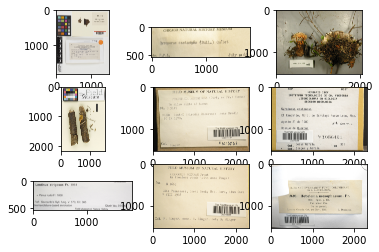

In [110]:
#domain_name = "data.huh.harvard.edu"
#domain_name = "data.huh.harvard.edu"                       # A supprimer ok
domain_name = "fm-digital-assets.fieldmuseum.org"          # A supprimer 
#domain_name = "observation.org"                             # A garder
#domain_name = "mycoportal.org"                             # A supprimer ok
#domain_name = "svampe.databasen.org/uploads/"
#domain_name = "data.landcareresearch.co.nz"
#domain_name = "s3.msi.umn.edu/"                              # A supprimer
#domain_name = "mediaphoto.mnhn.fr/media/"                    # A supprimer
#domain_name = "unimus.no/felles/"                            # A supprimer
#domain_name = "images.ala.org.au/image/"                      # A garder
#domain_name = "svampe.databasen.org/uploads"                  # A garder mais des images microscopiques
#domain_name = "oxalis.br.fgov.be/images"                      # A supprimer
#domain_name = "inaturalist-open-data.s3.amazonaws.com/photos"  # A garder
#domain_name = "repo.rbge.org.uk"                              # génère des erreurs de certificats (à creuser)
#domain_name = "media.canadensys.net"                           # des erreurs 404 mais ça semble ok de le garder

sub_df = df["identifier_y"].apply(lambda x: domain_name in x)
print(sub_df.value_counts())

nb_images = 9

# Selection de nb_images 
sample_df = df[sub_df].sample(nb_images)


for i in range (0, nb_images):
    plt.subplot(3,3,i+1)
    img = io.imread(sample_df.iloc[i].identifier_y)
    plt.imshow(img)

plt.show()

## Partie gestion des anomalies et reprise du téléchargement au bon endroit


In [ ]:
iddl_dl            #affichage de notreid où le script s'est arréter.

In [37]:
gene_to_dl=gene_to_dl[gene_to_dl.notreid>=1518374]    #modification du dataframe en ne reprenans que les motreid >= iddl_dl

In [128]:
number    #nombre d'image téléchargées lors du lancemant de ce script

9935